<a href="https://colab.research.google.com/github/brunoleme/Time_Series/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pmdarima

In [3]:
#!pip install chart_studio

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, arima

In [5]:
!pip install transformers

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import torch.utils.data as tdata
import torch.optim as optim

import tqdm

torch.manual_seed(0)
np.random.seed(0)

# **Data Prep**

The time series data used in this stuady was collected on Ipeadata, website managed by the Brazilian Institute of Applied Economic Research *(Instituto de Pesquisa Econômica Aplicada)* (Ipea). The mission of this institute is to make easier the access for brazillian statistics and to share the studies and researchs from Ipea.

Series info:
*   Name: *Faturamento real na indústria: índice (média 2006 = 100)*
*   Frequency: monthly from 1991.12 to 2020.09
*   Source: *Confederação Nacional da Indústria*

In [7]:
data = pd.read_csv('/content/drive/My Drive/Time_Series/Faturamento_Real_Industria.csv', sep=',', quotechar='"', decimal=',')

In [8]:
data.columns

Index(['Data',
       'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12',
       'Unnamed: 2'],
      dtype='object')

In [9]:
data = data.drop(['Unnamed: 2'], axis=1)

In [10]:
data.columns

Index(['Data', 'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12'], dtype='object')

Renaming columns.

In [11]:
new_column_names = ['date', 'value']

In [12]:
{c:new_c for c, new_c in zip(data.columns, new_column_names)}

{'Data': 'date',
 'Faturamento real - indústria - índice (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_VENREA12': 'value'}

In [13]:
data = data.rename(columns={c:new_c for c, new_c in zip(data.columns, new_column_names)})

In [14]:
data

,date,value
0,1991.12,48.9298103406456
1,1992.01,51.4594452614013
2,1992.02,51.69044906082
3,1992.03,54.1242662496314
4,1992.04,55.7037379103317
...,...,...
341,2020.05,84.5
342,2020.06,96.5
343,2020.07,109.6
344,2020.08,112


In [15]:
data.dtypes

date     object
value    object
dtype: object

Creating date features.

In [16]:
data['value'] = data['value'].astype(np.float64)
data['month'] = data['date'].apply(lambda x: int(str(x)[-2:]))
data['year'] = data['date'].apply(lambda x: int(str(x)[:4]))

In [17]:
data

,date,value,month,year
0,1991.12,48.929810,12,1991
1,1992.01,51.459445,1,1992
2,1992.02,51.690449,2,1992
3,1992.03,54.124266,3,1992
4,1992.04,55.703738,4,1992
...,...,...,...,...
341,2020.05,84.500000,5,2020
342,2020.06,96.500000,6,2020
343,2020.07,109.600000,7,2020
344,2020.08,112.000000,8,2020


## **Series Truncation**

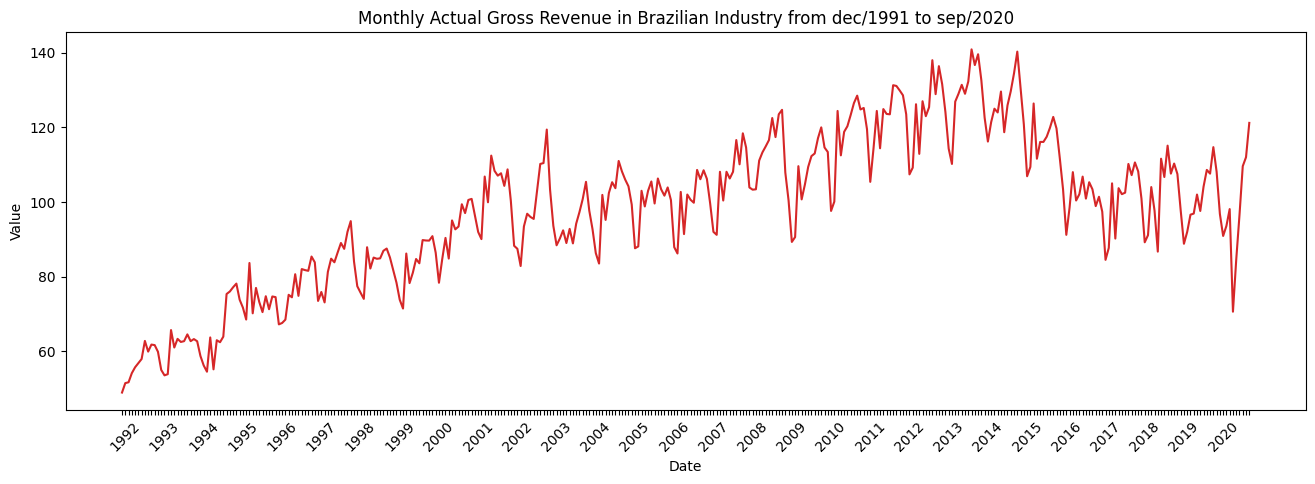

In [18]:
x = data.date
xlabel='Date'
y = data.value
ylabel='Value'
title='Monthly Actual Gross Revenue in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.xticks(np.arange(data.shape[0]), [year if month == 1 else None for month, year in data[['month', 'year']].values], rotation=45)  # Set text labels.
plt.show()

The series is really old, with data from 1991 untill 2020. For matter of simplicity, we'll truncate the series to consider observations only after 2005.

In [19]:
data = data[data['date'] >= '2005.01'].reset_index()

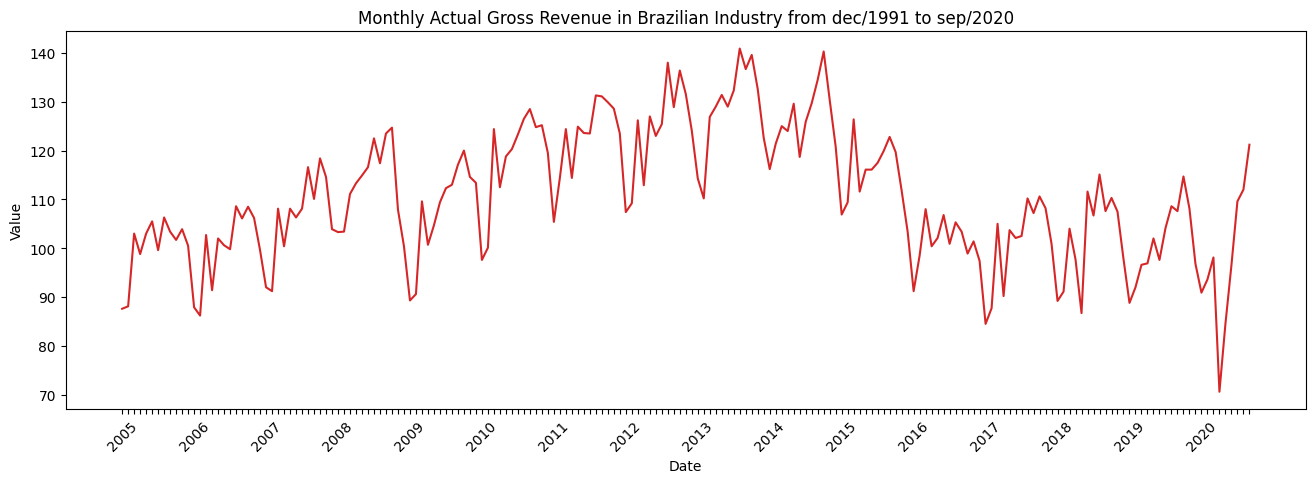

In [20]:
x = data.date
xlabel='Date'
y = data.value
ylabel='Value'
title='Monthly Actual Gross Revenue in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.xticks(np.arange(data.shape[0]), [year if month == 1 else None for month, year in data[['month', 'year']].values], rotation=45)  # Set text labels.
plt.show()

The series don't seem to be stationary (constant mean and variance), an assumption of the Box & Jenkins methodology, for adjusting ARIMA based models. We'll apply ADF and KPSS hypothesis tests to evaluate this.

We can observe that the mean increases from 20005 to 2014, decreases significantly between 2015 and 2016, and became constant from 2017 and on. Important to note the huge deceasing at the beggining of Covid-19 pandemy.

## **Exogenous Feature Engineering**

During the period of the second Dilma Roussef mandate, before she got impeached, Brazil suffered a long period of recession, in 2015 and 2016. Observing the graph, we can note a decreasing of Gross Revenue. We decided to create a feature to flag this period.

In [21]:
data['brazilian_economic_recession'] = data['date'].apply(lambda x: 1 if x >= '2015.01' and x <= '2016.12' else 0) 

In [22]:
data['pandemy_fall'] = data['date'].apply(lambda x: 1 if x == '2020.04' else 0) 

In [23]:
data['month_Jan'] = data['month'].apply(lambda x: 1 if x == 1 else 0)
data['month_Feb'] = data['month'].apply(lambda x: 1 if x == 2 else 0)
data['month_Mar'] = data['month'].apply(lambda x: 1 if x == 3 else 0)
data['month_Apr'] = data['month'].apply(lambda x: 1 if x == 4 else 0)
data['month_May'] = data['month'].apply(lambda x: 1 if x == 5 else 0)
data['month_Jun'] = data['month'].apply(lambda x: 1 if x == 6 else 0)
#data['month_Jul'] = data['month'].apply(lambda x: 1 if x == 7 else 0) # reference class
data['month_Aug'] = data['month'].apply(lambda x: 1 if x == 8 else 0)
data['month_Sep'] = data['month'].apply(lambda x: 1 if x == 9 else 0)
data['month_Oct'] = data['month'].apply(lambda x: 1 if x == 10 else 0)
data['month_Nov'] = data['month'].apply(lambda x: 1 if x == 11 else 0)
data['month_Dec'] = data['month'].apply(lambda x: 1 if x == 12 else 0)

In [24]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0


# **Exploratory Data Analysis**

## **Trend e Seasonality Analysis**

In following analysis, we'll check if we can observe some trend and seasonal patterns.

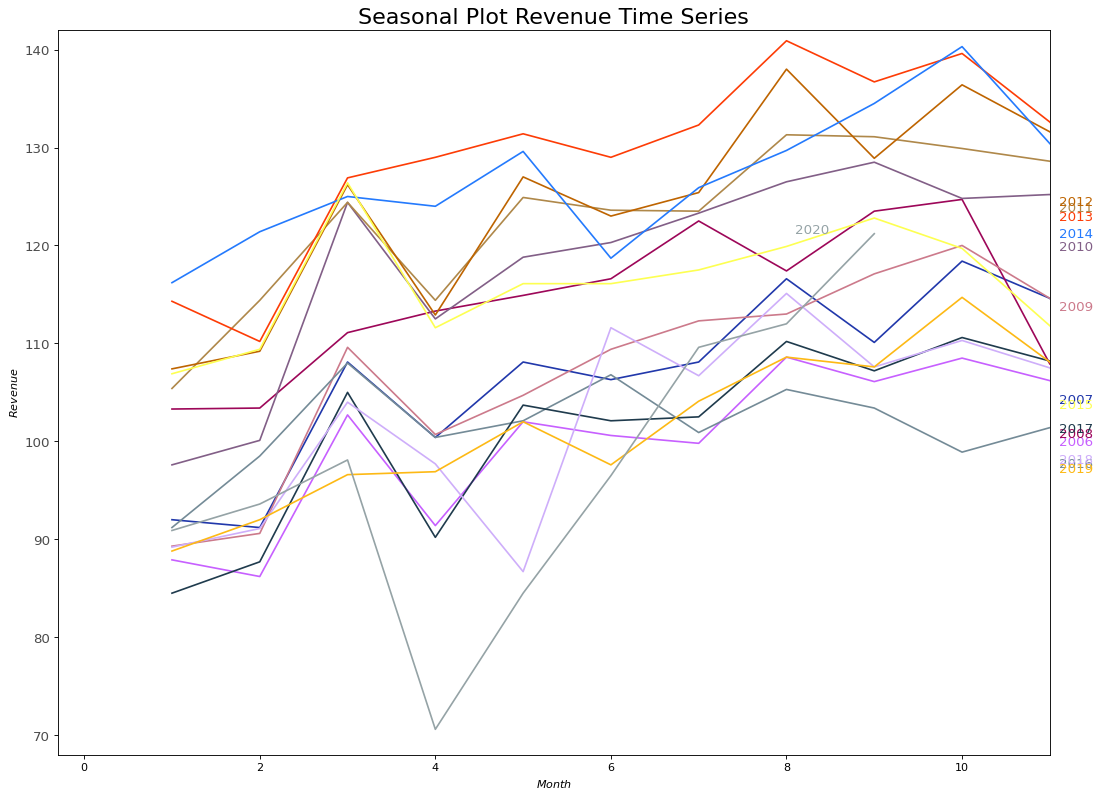

In [25]:
##Seasonal Plot of a Time Series

# Prepare data
years = data['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=data.loc[data.year==y, :], color=mycolors[i], label=y)
        plt.text(data.loc[data.year==y, :].shape[0]-.9, data.loc[data.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(68, 142), ylabel='$Revenue$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot Revenue Time Series", fontsize=20)
plt.show()

It seems that every year we have similar patterns along the months, just changing the stature of the series over the years. Let's analyse the variance patterns over years and months.

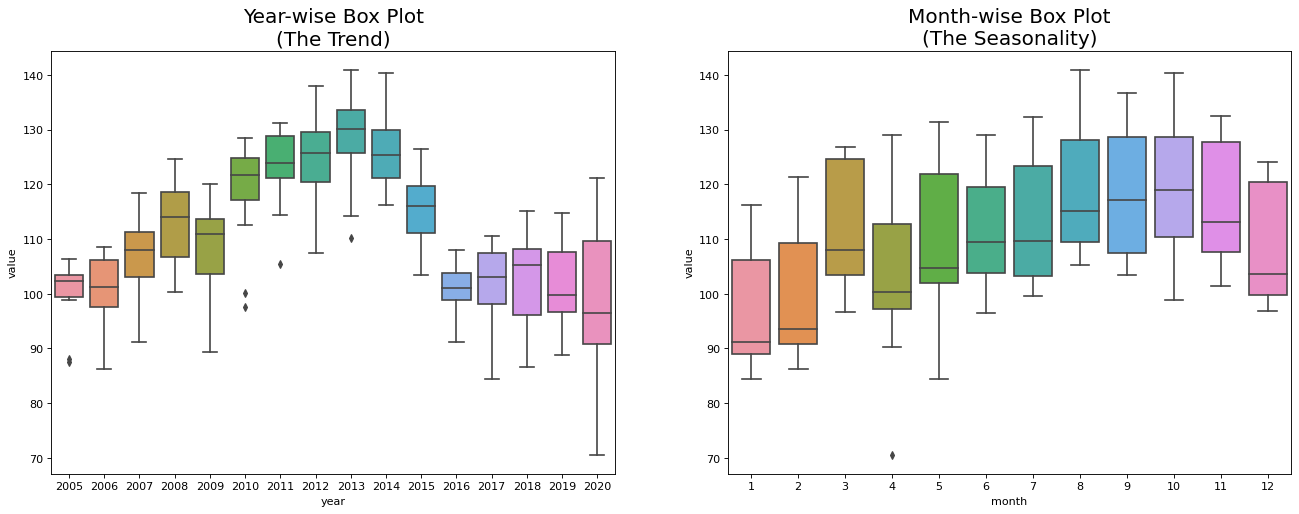

In [26]:
##Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=data, ax=axes[0])
sns.boxplot(x='month', y='value', data=data.loc[~data.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()


As observed before, the mean change over the years. Moreover, we can observe seasonal patterns over months, the value tend to be lower in january and february, with a pick in march, deacreasing in april, increasing untill october, and start deceasing in november and december.

We can also appy a seasonal decomposition in the series, separating it in trend, seasonal and residual parts. We cam actually observe a seasonal pattern, as well as how the trend changes over the time.

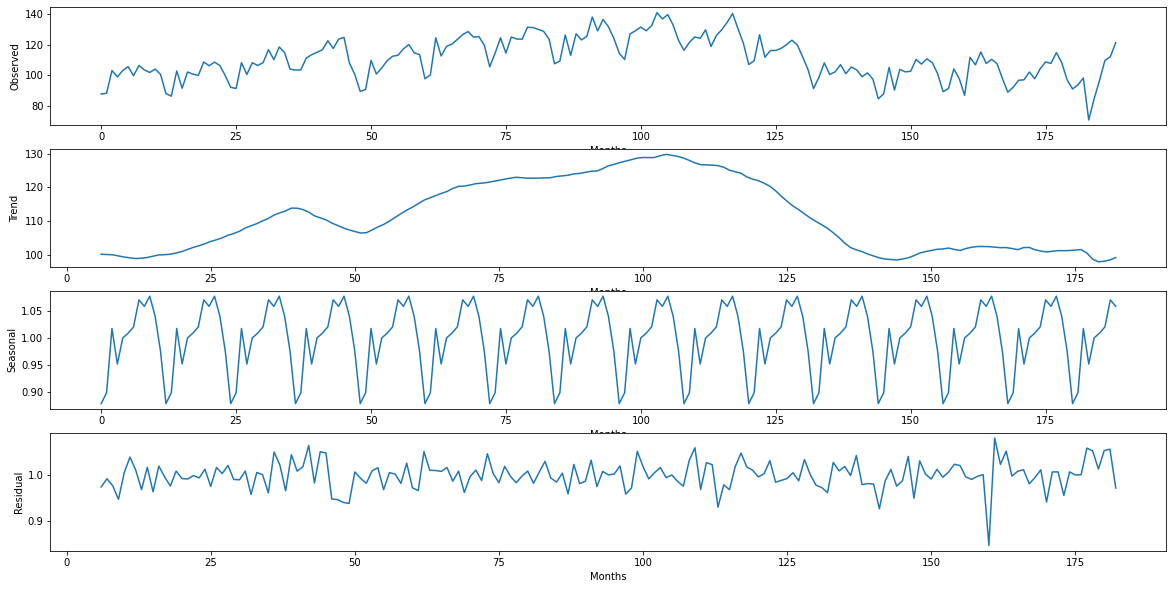

In [27]:
result = seasonal_decompose(data.value.values, model='multiplicative', period = 12)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,10))
ax1.set(xlabel='Months', ylabel='Observed')
ax1.plot(result.observed)
ax2.set(xlabel='Months', ylabel='Trend')
ax2.plot(result.trend)
ax3.set(xlabel='Months', ylabel='Seasonal')
ax3.plot(result.seasonal)
ax4.set(xlabel='Months', ylabel='Residual')
ax4.plot(result.resid)

# **Stationarity Evaluation**

In [28]:
# ADF Test
print('Time Series Stationary Test')
result = adfuller(data.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
print('Trend Stationary Test')
result = kpss(data.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Time Series Stationary Test
ADF Statistic: -1.8144698921610918
p-value: 0.37330182540375983
Critial Values:
   1%, -3.4685016947910636
Critial Values:
   5%, -2.8782983668563396
Critial Values:
   10%, -2.57570415906989
Trend Stationary Test

KPSS Statistic: 0.286053
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


ADF Statistic with p-value=0.37 indicates that the series is not stationary. Although KPSS Statistic indicates (with 90% of confidence) that the series is stationary along series trends.

We'll employ some series differentiation to transform it in a stationary series.

## **1st and 2nd Order of Differentiation**

In [29]:
data['value_diff1'] = data['value'].diff()
data['value_diff2'] = data['value_diff1'].diff()

In [30]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,value_diff1,value_diff2
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0,0.5,NaN
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0,14.9,14.4
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0,-4.2,-19.1
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0,4.2,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,13.9,41.4
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,-1.9
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,13.1,1.1
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0,2.4,-10.7


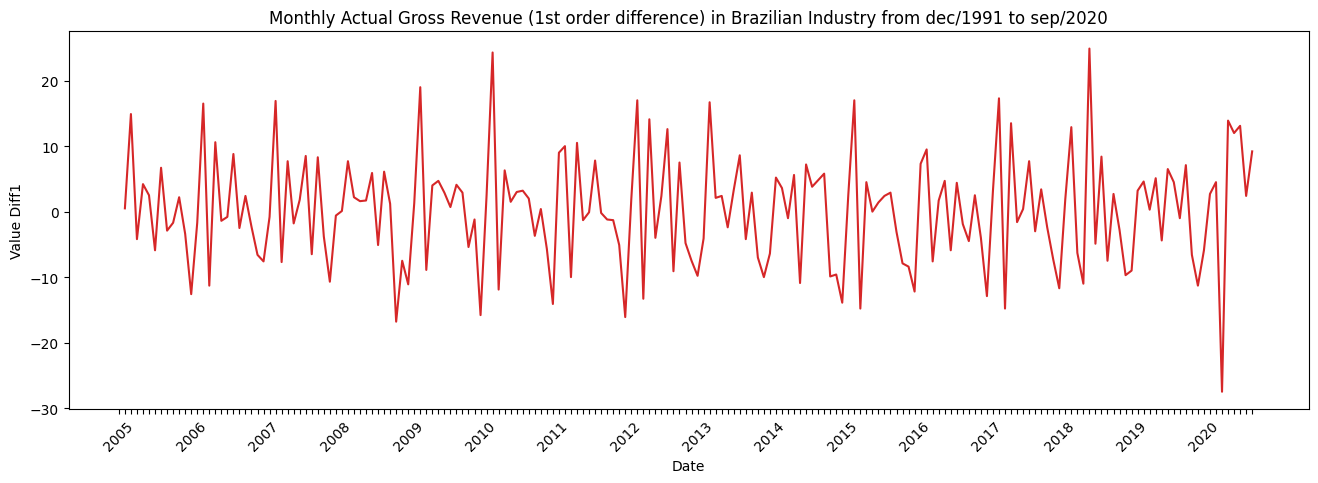

In [31]:
x = data.date
xlabel='Date'
y = data.value_diff1
ylabel='Value Diff1'
title='Monthly Actual Gross Revenue (1st order difference) in Brazilian Industry from dec/1991 to sep/2020'
plt.figure(figsize=(16,5), dpi=100)
plt.plot(x, y, color='tab:red')
plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
plt.xticks(np.arange(data.shape[0]), [year if month == 1 else None for month, year in data[['month', 'year']].values], rotation=45)  # Set text labels.
plt.show()

With series using first onder differentiation, it seems that now the series is stationary. We'll prove it applying the ADF and KPSS hypothesis tests again.

In [32]:
# ADF Test
print('Time Series Stationary Test')
result = adfuller(data.value_diff1.values[1:], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
print('Trend Stationary Test')
result = kpss(data.value_diff1.values[1:], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

Time Series Stationary Test
ADF Statistic: -2.913024542672198
p-value: 0.04385424894082136
Critial Values:
   1%, -3.4685016947910636
Critial Values:
   5%, -2.8782983668563396
Critial Values:
   10%, -2.57570415906989
Trend Stationary Test

KPSS Statistic: 0.104320
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Now the series is stationary, according with ADF Statistics p-value (0.04)

In [33]:
data

,index,date,value,month,year,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,value_diff1,value_diff2
0,157,2005.01,87.6,1,2005,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,158,2005.02,88.1,2,2005,0,0,0,1,0,0,0,0,0,0,0,0,0,0.5,NaN
2,159,2005.03,103.0,3,2005,0,0,0,0,1,0,0,0,0,0,0,0,0,14.9,14.4
3,160,2005.04,98.8,4,2005,0,0,0,0,0,1,0,0,0,0,0,0,0,-4.2,-19.1
4,161,2005.05,103.0,5,2005,0,0,0,0,0,0,1,0,0,0,0,0,0,4.2,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,341,2020.05,84.5,5,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,13.9,41.4
185,342,2020.06,96.5,6,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0,-1.9
186,343,2020.07,109.6,7,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,13.1,1.1
187,344,2020.08,112.0,8,2020,0,0,0,0,0,0,0,0,1,0,0,0,0,2.4,-10.7


# **Data Partition**

Let's use an out-of-time sample to test our models. We'll reserve the last 20% of months as a test sample, the first 80% of months will be use as a train sample.

In [34]:
data_train = data[:-int(round(len(data) * 0.2))]
data_test = data[-int(round(len(data) * 0.2)):]

In [35]:
data_train[['date']]

,date
0,2005.01
1,2005.02
2,2005.03
3,2005.04
4,2005.05
...,...
146,2017.03
147,2017.04
148,2017.05
149,2017.06


In [36]:
data_test[['date']].head(10)

,date
151,2017.08
152,2017.09
153,2017.10
154,2017.11
155,2017.12
156,2018.01
157,2018.02
158,2018.03
159,2018.04
160,2018.05


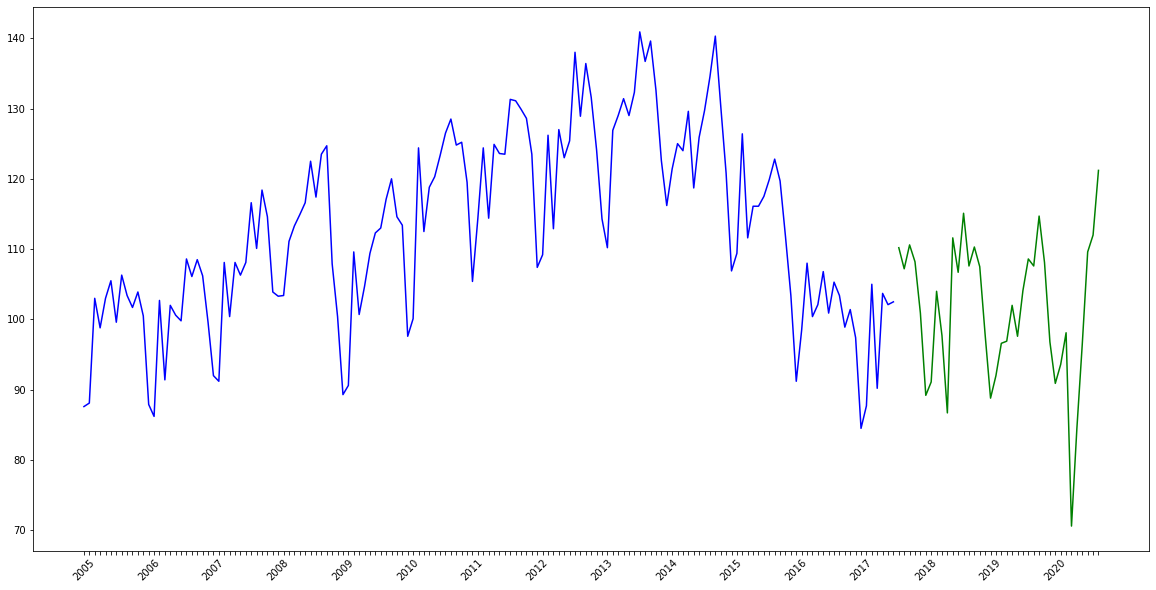

In [37]:
plt.figure(figsize=(20,10))

plt.plot(data_train.index.values, data_train.value.values, 'b') # plotting t, b separately 
plt.plot(data_test.index.values, data_test.value.values, 'g') # plotting t, c separately 
plt.xticks(np.arange(data.shape[0]), [year if month == 1 else None for month, year in data[['month', 'year']].values], rotation=45)  # Set text labels.
plt.show()

# **Modelling**

## **Model 1 - SARIMA**

We'll use the Box & Jenkins methodology to adjust ARIMA based models.

### **Order Identification**

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


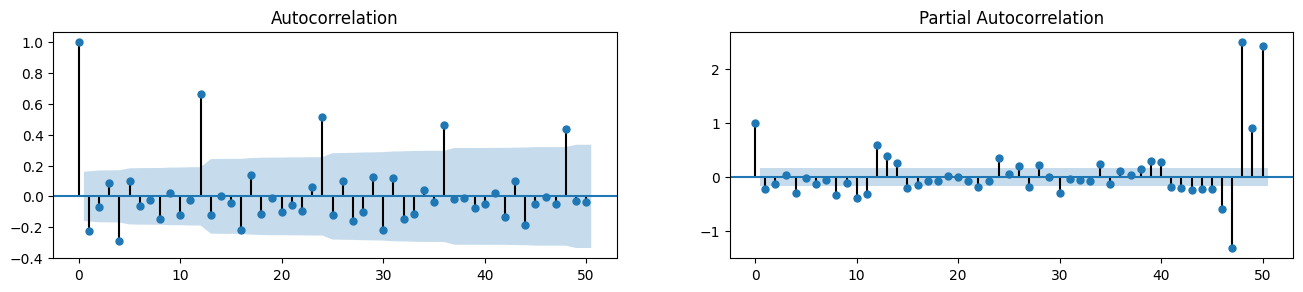

In [38]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_train.value_diff1[1:].tolist(), lags=50, ax=axes[0])
plot_pacf(data_train.value_diff1[1:].tolist(), lags=50, ax=axes[1])
plt.show()

Following Box & Jenkins methodology, in both Autocorrelation and Partial Autocorrelation graphs, we cannot observe a truncation after some time lags, we have some sporadic values different from zero. We'll try to adjust the model with both AR (autoregressive) and MA (moving average) terms.

We can note a cyclical pattern, from 12 to 12 months in Autocorrelation graph, and not so clear in Partial Autocorrelation graph, indicading that seasonal terms with 12 cycles could be useful.

Furthermore, we can note in Autocorrelation graph that the lags 1 and 4 are differents of zero, we'll start our AR order with 4. In Partial Autocorrelation graph, we can observe lots of lags with value different from zero (lags 1, 4, 6, 8, 10 and 11). we'll start our AR order with 11.

As seen before, we need use a differentiation to turn the series stationary, that's why we'll consider a differentiation order of 1 in arima model.

Considering all these aspects, we'll try to adjust a SARIMA model, with (SARIMAX) or without endogenous variables.

### **Testing SARIMA with vs without intercept**

In [39]:
model_with_intercept_diff1 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=True)
model_with_intercept_diff1_fit = model_with_intercept_diff1.fit(data_train.value)
model_with_intercept_diff1_fit.aic()

789.2134034015619

In [40]:
model_with_intercept_diff1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -372.607
Date:                               Sun, 06 Dec 2020   AIC                            789.213
Time:                                       02:01:58   BIC                            853.613
Sample:                                            0   HQIC                           815.384
                                               - 151                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2816      0.209     -1.346      0.178      -0.692       0.128
ar.L1         -0.0594      0.476     -0.125      0.901      -0.992       0.873
ar.L2          0.6383      0.344      1.855      0.064      -0.036       1.313
ar.L3         -0.3726      0.203     -1.838      0.066      -0.770       0.025
ar.L4         -0.6226      0.339     -1.838      0.066      -1.287       0.041
ma.L1         -0.3490      0.483     -0.723      0.470      -1.295       0.598
ma.L2         -0.7048      0.539     -1.308      0.191      -1.761       0.351
ma.L3          0.8542      0.185      4.628      0.000       0.492       1.216
ma.L4          0.2730      0.533      0.512      0.608      -0.771       1.317
ma.L5         -0.2514      0.352     -0.715      0.475      -0.941       0.438
ma.L6          0.3017      0.213      1.414      0.157      -0.116       0.720
ma.L7         -0.2365      0.169     -1.402      0.161      -0.567       0.094
ma.L8         -0.1393      0.323     -0.431      0.667      -0.773       0.495
ma.L9          0.4769      0.189      2.521      0.012       0.106       0.848
ma.L10        -0.1773      0.213     -0.833      0.405      -0.595       0.240
ma.L11        -0.1947      0.266     -0.733      0.464      -0.715       0.326
ar.S.L12      -0.1376      0.149     -0.921      0.357      -0.430       0.155
ar.S.L24      -0.4388      0.121     -3.618      0.000      -0.676      -0.201
ar.S.L36      -0.2441      0.115     -2.124      0.034      -0.469      -0.019
ar.S.L48      -0.5300      0.121     -4.364      0.000      -0.768      -0.292
ma.S.L12      -0.5536      0.230     -2.402      0.016      -1.005      -0.102
sigma2         9.7354      1.484      6.559      0.000       6.826      12.644
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.76   Prob(JB):                         0.29
Heteroskedasticity (H):               1.00   Skew:                            -0.27
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_without_intercept_diff1 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
model_without_intercept_diff1_fit = model_without_intercept_diff1.fit(data_train.value)
model_without_intercept_diff1_fit.aic()

788.3859019601198

In [42]:
model_without_intercept_diff1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -373.193
Date:                               Sun, 06 Dec 2020   AIC                            788.386
Time:                                       02:02:26   BIC                            849.858
Sample:                                            0   HQIC                           813.367
                                               - 151                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2516      0.378     -0.666      0.505      -0.992       0.489
ar.L2          0.7650      0.280      2.731      0.006       0.216       1.314
ar.L3         -0.3802      0.163     -2.329      0.020      -0.700      -0.060
ar.L4         -0.7179      0.265     -2.708      0.007      -1.237      -0.198
ma.L1         -0.1346      0.371     -0.363      0.717      -0.862       0.593
ma.L2         -0.8828      0.408     -2.162      0.031      -1.683      -0.082
ma.L3          0.9234      0.201      4.595      0.000       0.530       1.317
ma.L4          0.4324      0.394      1.097      0.273      -0.340       1.205
ma.L5         -0.3141      0.271     -1.158      0.247      -0.846       0.218
ma.L6          0.3844      0.213      1.805      0.071      -0.033       0.802
ma.L7         -0.1834      0.172     -1.068      0.286      -0.520       0.153
ma.L8         -0.1509      0.245     -0.615      0.539      -0.632       0.330
ma.L9          0.4954      0.167      2.969      0.003       0.168       0.822
ma.L10        -0.0956      0.203     -0.471      0.638      -0.494       0.303
ma.L11        -0.2283      0.205     -1.111      0.267      -0.631       0.174
ar.S.L12      -0.2080      0.164     -1.266      0.206      -0.530       0.114
ar.S.L24      -0.4944      0.119     -4.141      0.000      -0.728      -0.260
ar.S.L36      -0.2722      0.112     -2.440      0.015      -0.491      -0.054
ar.S.L48      -0.5755      0.111     -5.176      0.000      -0.793      -0.358
ma.S.L12      -0.4067      0.242     -1.683      0.092      -0.880       0.067
sigma2         9.9739      1.522      6.553      0.000       6.991      12.957
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.64   Prob(JB):                         0.38
Heteroskedasticity (H):               1.03   Skew:                            -0.24
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model without intercept has shown to be slightly better.

### **Adjusting a SARIMAX model**

Testing if the exogenous features are significant for the model adjustment.

In [43]:
exogenous_features = ['brazilian_economic_recession', 'pandemy_fall', 'month_Jan', 'month_Feb',
       'month_Mar', 'month_Apr', 'month_May', 'month_Jun', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec']

In [44]:
model_without_intercept_diff1_2 = arima.ARIMA(order=(4, 1, 11), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
model_without_intercept_diff1_fit_2 = model_without_intercept_diff1_2.fit(data_train.value, data_train[exogenous_features])
model_without_intercept_diff1_fit_2.aic()

815.6033491356716

The model got worse (AIC increased from 788 to 815). Let's try some feature selection procedure.

In [45]:
model_without_intercept_diff1_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  151
Model:             SARIMAX(4, 1, 11)x(4, 1, [1], 12)   Log Likelihood                -373.802
Date:                               Sun, 06 Dec 2020   AIC                            815.603
Time:                                       02:03:11   BIC                            915.130
Sample:                                            0   HQIC                           856.049
                                               - 151                                         
Covariance Type:                                 opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
brazilian_economic_recession    -4.5927      3.276     -1.402      0.161     -11.013       1.828
pandemy_fall                          0   2.04e+05          0      1.000      -4e+05       4e+05
month_Jan                    -8.011e-05   3.43e+05  -2.34e-10      1.000   -6.71e+05    6.71e+05
month_Feb                    -3.746e-05   3.57e+05  -1.05e-10      1.000   -7.01e+05    7.01e+05
month_Mar                        0.0002    2.9e+05   6.68e-10      1.000   -5.69e+05    5.69e+05
month_Apr                       -0.0002   3.19e+05  -5.29e-10      1.000   -6.25e+05    6.25e+05
month_May                        0.0001    4.3e+05   2.34e-10      1.000   -8.43e+05    8.43e+05
month_Jun                       -0.0002   3.15e+05  -6.33e-10      1.000   -6.17e+05    6.17e+05
month_Aug                    -5.555e-05   3.51e+05  -1.58e-10      1.000   -6.88e+05    6.88e+05
month_Sep                    -2.989e-05   2.21e+05  -1.35e-10      1.000   -4.34e+05    4.34e+05
month_Oct                     9.634e-05   2.48e+05   3.89e-10      1.000   -4.86e+05    4.86e+05
month_Nov                    -3.029e-05   2.79e+05  -1.09e-10      1.000   -5.47e+05    5.47e+05
month_Dec                     1.054e-05    2.1e+05   5.02e-11      1.000   -4.11e+05    4.11e+05
ar.L1                           -0.0101      0.871     -0.012      0.991      -1.717       1.697
ar.L2                            0.5612      0.407      1.378      0.168      -0.237       1.359
ar.L3                           -0.3349      0.392     -0.854      0.393      -1.103       0.434
ar.L4                           -0.4432      0.496     -0.894      0.372      -1.415       0.529
ma.L1                           -0.3915      0.879     -0.445      0.656      -2.114       1.331
ma.L2                           -0.6178      0.720     -0.859      0.391      -2.028       0.793
ma.L3                            0.8098      0.351      2.306      0.021       0.121       1.498
ma.L4                            0.1022      0.852      0.120      0.904      -1.567       1.771
ma.L5                           -0.1465      0.486     -0.302      0.763      -1.098       0.805
ma.L6                            0.2388      0.237      1.009      0.313      -0.225       0.703
ma.L7                           -0.2633      0.217     -1.216      0.224      -0.688       0.161
ma.L8                            0.0222      0.438      0.051      0.960      -0.836       0.880
ma.L9                            0.3736      0.284      1.317      0.188      -0.182       0.930
ma.L10                          -0.2772      0.242     -1.144      0.253      -0.752       0.198
ma.L11                          -0.0863      0.366     -0.236      0.814      -0.804       0.631
ar.S.L12                        -0.2363      0.184     -1.282      0.200      -0.598       0.125
ar

### **Backward Exogenous Feature Elimination Procedure**

Similar procedure used in Linear and Logistic Regression, in some statistical softwares.

In [46]:
#Implementing backward feature selection procedure to drop non-relevant features
def backward_exogenous_feature_selection(ts_model, exogenous_features, data, auto_arima = False):
  backward_exogenous_features = exogenous_features
  features = np.array([feature for feature, pvalue in ts_model.pvalues().iteritems() if feature in exogenous_features])
  pvalues = np.array([pvalue for feature, pvalue in ts_model.pvalues().iteritems() if feature in exogenous_features])
  while np.sum(pvalues >= 0.1) > 0:
    drop_feature = features[np.argmax(pvalues)]
    pvalue = pvalues[np.argmax(pvalues)]
    print('Dropping feature...', drop_feature, '| p_value =', pvalue)
    backward_exogenous_features = [feature for feature in backward_exogenous_features if feature != drop_feature]
    if len(backward_exogenous_features) == 0:
      ts_model.fit(data.value)
      print(ts_model.aic())
      break
    ts_model.fit(data.value, data[backward_exogenous_features])
    print(ts_model.aic())
    features = np.array([feature for feature, pvalue in ts_model.pvalues().iteritems() if feature in backward_exogenous_features])
    pvalues = np.array([pvalue for feature, pvalue in ts_model.pvalues().iteritems() if feature in backward_exogenous_features])
  print(ts_model.summary())
  return ts_model

In [47]:
model_without_intercept_diff1_fit_3 = backward_exogenous_feature_selection(ts_model=model_without_intercept_diff1_fit_2, exogenous_features=exogenous_features, data=data_train)

Dropping feature... pandemy_fall | p_value = 1.0
813.6480030815416
Dropping feature... month_Dec | p_value = 0.9999999999622384
811.718815224214
Dropping feature... month_Feb | p_value = 0.9999999999112432
809.5120831519147
Dropping feature... month_Nov | p_value = 0.9999999998997213
807.7119950605397
Dropping feature... month_Sep | p_value = 0.9999999998141406
805.5228419428906
Dropping feature... month_Aug | p_value = 0.9999999998469599
803.7645948052434
Dropping feature... month_May | p_value = 0.9999999996470089
801.7384760889396
Dropping feature... month_Jan | p_value = 0.9999999996370671
799.5912082220364
Dropping feature... month_Oct | p_value = 0.9999999995691619
797.7751462339918
Dropping feature... month_Jun | p_value = 0.9999999993941701
795.691893712921
Dropping feature... month_Apr | p_value = 0.9999999988776137
793.6815219850621
Dropping feature... month_Mar | p_value = 0.9999999882700861
791.5896366882251
Dropping feature... brazilian_economic_recession | p_value = 0.160

All features proved not to be relevants for the model. But we can observe that lots of MA lags are not significant for the model. As we have MA lags (from 1 to 11) with and without autocorrelation different from zero, we'll test in a looping, which q is optimal for the model.

### **Finding de Optimal Order of q**

In [48]:
best_q = -1
best_aic = 9999999
best_model = None
for q in range(11 + 1):
  model_without_intercept_diff1_fit_3_best = arima.ARIMA(order=(4, 1, q), seasonal_order=(4, 1, 1, 12), start_params=None, method='lbfgs', maxiter=50, suppress_warnings=True, out_of_sample_size=0, scoring='mse', scoring_args=None, trend=None, with_intercept=False)
  model_without_intercept_diff1_fit_3_best = model_without_intercept_diff1_fit_3_best.fit(data_train.value) 
  if model_without_intercept_diff1_fit_3_best.aic() < best_aic:
    best_aic = model_without_intercept_diff1_fit_3_best.aic()
    best_q = q
    best_model = model_without_intercept_diff1_fit_3_best
    print('new best q = {} and aic = {}'.format(best_q, best_aic))
  else:
    print('q = {} and aic = {}'.format(q, model_without_intercept_diff1_fit_3_best.aic()))

new best q = 0 and aic = 779.3594533100935
q = 1 and aic = 781.3497130760574
q = 2 and aic = 780.443726201839
q = 3 and aic = 782.1930651953326
q = 4 and aic = 788.4645284094572
q = 5 and aic = 782.6034410612156
q = 6 and aic = 784.457526779624
q = 7 and aic = 786.2708793069478
q = 8 and aic = 788.6150246807525
q = 9 and aic = 788.3871847131895
q = 10 and aic = 789.7452487102457
q = 11 and aic = 788.3859019601198


In [49]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  151
Model:             SARIMAX(4, 1, 0)x(4, 1, [1], 12)   Log Likelihood                -379.680
Date:                              Sun, 06 Dec 2020   AIC                            779.359
Time:                                      02:14:48   BIC                            808.632
Sample:                                           0   HQIC                           791.255
                                              - 151                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3912      0.093     -4.186      0.000      -0.574      -0.208
ar.L2         -0.1339      0.098     -1.359      0.174      -0.327       0.059
ar.L3          0.1613      0.086      1.870      0.062      -0.008       0.330
ar.L4         -0.1125      0.086     -1.312      0.190      -0.280       0.056
ar.S.L12      -0.2200      0.129     -1.700      0.089      -0.474       0.034
ar.S.L24      -0.4476      0.119     -3.777      0.000      -0.680      -0.215
ar.S.L36      -0.2718      0.113     -2.398      0.016      -0.494      -0.050
ar.S.L48      -0.5391      0.106     -5.087      0.000      -0.747      -0.331
ma.S.L12      -0.5757      0.193     -2.984      0.003      -0.954      -0.198
sigma2        11.2770      1.464      7.703      0.000       8.407      14.147
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.88   Prob(JB):                         0.73
Heteroskedasticity (H):               1.38   Skew:                            -0.16
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

q=0 proved to be the best for this model.

### **Autoarima Procedure**

Let's try to use the autoarima procedure, to see if we find a better model than the previous one.

In [50]:
auto_model_diff1 = auto_arima(data_train.value, start_p=4, start_q=1,
                           max_p=4, max_q=11, m=12,
                           start_P=4, start_Q=1, seasonal=True,
                           max_P=4, max_Q=1,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_model_diff1.summary())

Performing stepwise search to minimize aic
 ARIMA(4,1,1)(4,1,1)[12]             : AIC=781.350, Time=7.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=890.495, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=851.110, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(4,1,1)(3,1,1)[12]             : AIC=inf, Time=9.55 sec
 ARIMA(4,1,1)(4,1,0)[12]             : AIC=789.282, Time=4.28 sec
 ARIMA(4,1,1)(3,1,0)[12]             : AIC=815.677, Time=2.22 sec
 ARIMA(3,1,1)(4,1,1)[12]             : AIC=779.798, Time=6.59 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=7.82 sec
 ARIMA(3,1,1)(4,1,0)[12]             : AIC=787.881, Time=4.02 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=815.379, Time=1.52 sec
 ARIMA(2,1,1)(4,1,1)[12]             : AIC=778.923, Time=6.78 sec
 ARIMA(2,1,1)(3,1,1)[12]             : AIC=inf, Time=7.47 sec
 ARIMA(2,1,1)(4,1,0)[12]             : AIC=786.401, Time=3.50 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=813.57

Autoarima found a model slightly better than the previous one. Let's select it as our final model.

### **Residual Analysis for the Best Model**

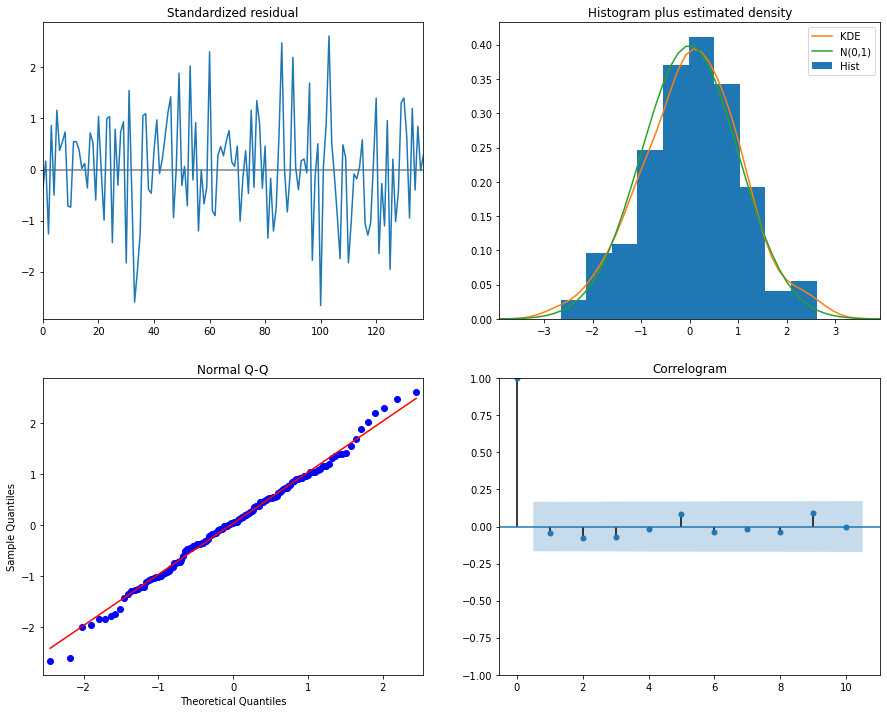

In [51]:
auto_model_diff1.plot_diagnostics(figsize=(15,12))
plt.show()

We cannot observe in any lag a residual with value different from zero in the residual autocorrelation analyis, so we don't need to add another term to the model.

### **Fitting and Forecast Evaluation**

Getting the estimated series, from the train series data (seen data).

In [52]:
# Actual vs Fitted
predictions = auto_model_diff1.predict_in_sample()

In [53]:
np.set_printoptions(suppress=True)

Forecasting the series to the period of test series data (unseen data).

In [54]:
forecast = auto_model_diff1.predict(len(data_test), alpha=0.05)  # 95% conf

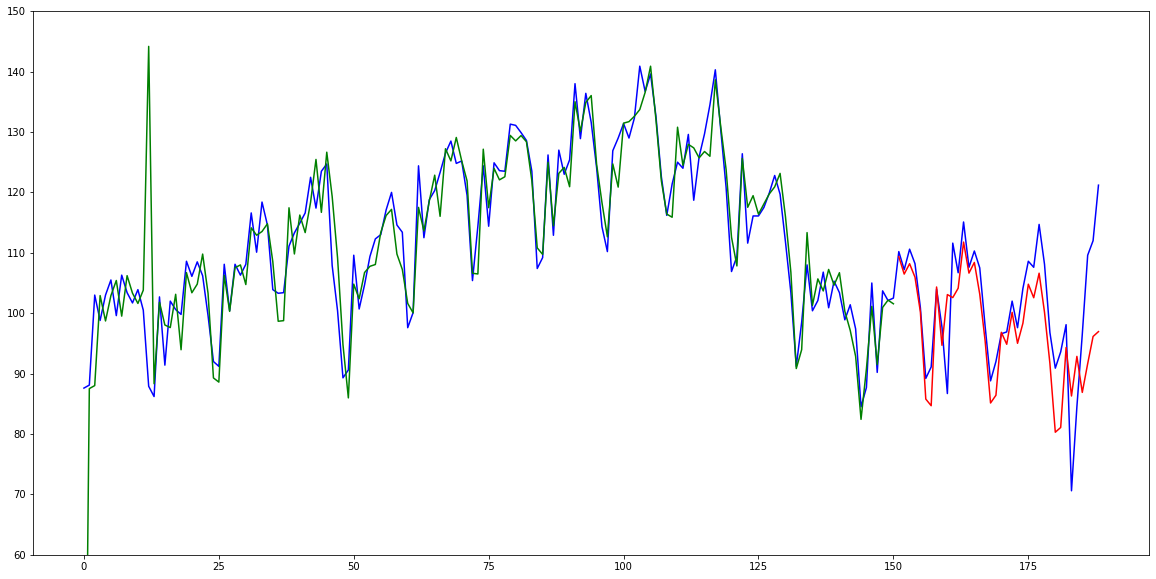

In [55]:
plt.figure(figsize=(20,10))
plt.plot(data.index.values, data.value.values, 'b') # plotting t, b separately 
plt.plot(data_train.index.values, predictions, 'g') # plotting t, c separately 
plt.plot(data_test.index.values, forecast, 'r') # plotting t, c separately 
plt.gca().set(ylim=(60, 150))
plt.show()

We can note a good fit of the model.

### **Model Evaluation**

In [56]:
rmse_train = np.mean((data_train[3:].value.values - predictions[3:])**2)**.5  # RMSE TRAIN
rmse_test = np.mean((data_test.value.values - forecast)**2)**.5  # RMSE TEST
print('RMSE Train', rmse_train)
print('RMSE Test', rmse_test)

RMSE Train 5.95446090756357
RMSE Test 8.289582730314141


In [57]:
results = []

In [58]:
results.append(['Model 1 - SARIMA',
      rmse_train,
      rmse_test
])

## **Model 2 - LSTM (PyTorch)**

Now, we'll try a different aproach, using LSTM model to create a time series model. We'll adjust the modelo to learn how to predict the value with first differentiation.

PS: I tried to model the raw series, but it doesn't fit at all in this way.

### **Target Creation**

Shifting the series to get the next lag for each time step, in order to specify the target value.

In [59]:
# create lagged dataset
lagged_data_train = pd.concat([data_train.value.shift(1), data_train.value], axis=1)
lagged_data_train = pd.concat([data_train[['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features].shift(1), data_train.value_diff1], axis=1)
lagged_data_train.columns = ['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features + ['t+1']

In [60]:
lagged_data_train

,value,value_diff1,value_diff2,month,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec,t+1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.6,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,88.1,0.5,NaN,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.9
3,103.0,14.9,14.4,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.2
4,98.8,-4.2,-19.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,87.7,3.2,16.1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.3
147,105.0,17.3,14.1,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.8
148,90.2,-14.8,-32.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.5
149,103.7,13.5,28.3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.6


### **Splitting X and Y datasets**

In [61]:
X_samples = lagged_data_train[3:].drop(['t+1'], axis=1)
Y_samples = lagged_data_train[3:]['t+1']

In [62]:
X_samples

,value,value_diff1,value_diff2,month,brazilian_economic_recession,pandemy_fall,month_Jan,month_Feb,month_Mar,month_Apr,month_May,month_Jun,month_Aug,month_Sep,month_Oct,month_Nov,month_Dec
3,103.0,14.9,14.4,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,98.8,-4.2,-19.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,103.0,4.2,8.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,105.5,2.5,-1.7,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,99.6,-5.9,-8.4,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,87.7,3.2,16.1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,105.0,17.3,14.1,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,90.2,-14.8,-32.1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,103.7,13.5,28.3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
Y_samples

3      -4.2
4       4.2
5       2.5
6      -5.9
7       6.7
       ... 
146    17.3
147   -14.8
148    13.5
149    -1.6
150     0.4
Name: t+1, Length: 148, dtype: float64

### **Tensors Creation**

In [64]:
X_train_tensor = torch.from_numpy(np.array(X_samples)).float().unsqueeze(0)
Y_train_tensor = torch.from_numpy(np.array(Y_samples)).float()

In [65]:
X_train_tensor.shape

torch.Size([1, 148, 17])

In [66]:
Y_train_tensor.shape

torch.Size([148])

### **Model Specification**

We'll try an LSTM with 2 layers, using all (17) availble input features (endogenous, the raw value, and the value with 1st and 2nd differentiation), try to predict the next value of 1st differentiation.

In [67]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        hidden_dim = 50
        num_layers = 2
        num_features = 17

        self.lstm = nn.LSTM(num_features, hidden_dim, num_layers)
        
        self.fc_out = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        lstm_out, hidden = self.lstm(x)
        h = self.dropout(lstm_out)

        y = self.fc_out(h)
        return y.squeeze(1).squeeze(1)

In [68]:
criterion = nn.MSELoss() #Mean Squared Error Loss Function

In [69]:
model = LSTM()

### **Model Training**

In [70]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=0.05)

In [71]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [72]:
for i in range(130):
  model.train()
  optimizer.zero_grad()
  prediction = model(X_train_tensor)
  loss = criterion(prediction, Y_train_tensor)
  loss.backward()
  optimizer.step()

  print(i, float(loss.cpu()))

0 64.07630920410156
1 64.67947387695312
2 64.36795806884766
3 64.33406829833984
4 64.29732513427734
5 64.40861511230469
6 64.00685119628906
7 63.661338806152344
8 63.50038146972656
9 62.5472526550293
10 62.84660720825195
11 61.993019104003906
12 59.8890266418457
13 59.024776458740234
14 59.048431396484375
15 56.697593688964844
16 52.9630241394043
17 54.004905700683594
18 48.8087043762207
19 48.36080551147461
20 45.5573844909668
21 38.25371551513672
22 45.0380744934082
23 44.1440315246582
24 40.497135162353516
25 35.07874298095703
26 41.8144416809082
27 33.85652542114258
28 29.74591827392578
29 32.02626037597656
30 27.53572654724121
31 31.261240005493164
32 23.81718635559082
33 25.45123863220215
34 22.528472900390625
35 28.056974411010742
36 23.805156707763672
37 24.571090698242188
38 20.879314422607422
39 21.19782829284668
40 23.09082794189453
41 20.199424743652344
42 23.410863876342773
43 20.56720542907715
44 20.20218276977539
45 21.12798500061035
46 19.351648330688477
47 19.796241760

### **Model Forecasting**

We need to pretend we don't know the test series values, we need to predict over predictions (value, 1st diff value and 2nd diff value) after the last month of train dataset.

In [73]:
new_data = data[3:len(data_train)][['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features]

In [74]:
for _ in range(len(data_test)):
  new_X_train_tensor = torch.from_numpy(np.array(new_data.values)).float().unsqueeze(0)
  new_value_diff1 = model(new_X_train_tensor).detach().numpy()[-1]
  new_X_last = new_data[-1:]
  index_row = new_X_last.index[0]
  dict_row = new_X_last.to_dict()
  new_value = dict_row['value'][index_row] + new_value_diff1
  value_diff1 = dict_row['value_diff1'][index_row]
  new_value_diff2 = new_value_diff1 - value_diff1
  new_index_row = index_row + 1

  month_Jul = 1 if (dict_row['month_Jan'][index_row] + dict_row['month_Feb'][index_row] + dict_row['month_Mar'][index_row] + dict_row['month_Apr'][index_row] +
                dict_row['month_May'][index_row] + dict_row['month_Jun'][index_row] + dict_row['month_Aug'][index_row] + dict_row['month_Sep'][index_row] +
                dict_row['month_Oct'][index_row] + dict_row['month_Nov'][index_row] + dict_row['month_Dec'][index_row]) == 0 else 0
  month = dict_row['month'][index_row]

  new_dict_row = {'brazilian_economic_recession': {new_index_row: 0},
  'month': {new_index_row: month + 1 if month < 12 else 1},
  'month_Apr': {new_index_row: dict_row['month_Mar'][index_row]},
  'month_Aug': {new_index_row: month_Jul},
  'month_Dec': {new_index_row: dict_row['month_Nov'][index_row]},
  'month_Feb': {new_index_row: dict_row['month_Jan'][index_row]},
  'month_Jan': {new_index_row: dict_row['month_Dec'][index_row]},
  'month_Jun': {new_index_row: dict_row['month_May'][index_row]},
  'month_Mar': {new_index_row: dict_row['month_Feb'][index_row]},
  'month_May': {new_index_row: dict_row['month_Apr'][index_row]},
  'month_Nov': {new_index_row: dict_row['month_Oct'][index_row]},
  'month_Oct': {new_index_row: dict_row['month_Sep'][index_row]},
  'month_Sep': {new_index_row: dict_row['month_Aug'][index_row]},
  'pandemy_fall': {new_index_row: 0},
  'value': {new_index_row: new_value},
  'value_diff1': {new_index_row: new_value_diff1},
  'value_diff2': {new_index_row: new_value_diff2}}

  new_row = pd.DataFrame(new_dict_row)[['value', 'value_diff1', 'value_diff2', 'month'] + exogenous_features]

  new_data = pd.concat([new_data, new_row], axis=0)

### **Fitting and Forecast Evaluation**

In [75]:
prediction_series_values = lagged_data_train[3:].value.values + prediction.detach().numpy()

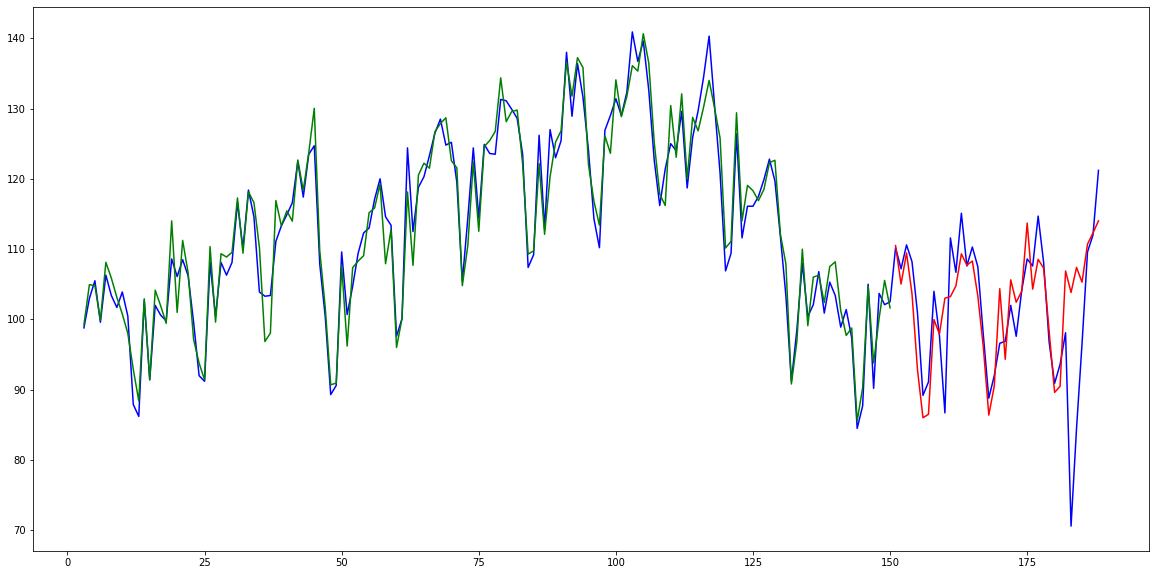

In [76]:
plt.figure(figsize=(20,10))
plt.plot(data[3:].index.values, data[3:].value.values, 'b') # plotting t, b separately 
plt.plot(data_train[3:].index.values, prediction_series_values, 'g') # plotting t, c separately 
plt.plot(new_data[-len(data_test):].index.values, new_data[-len(data_test):].value.values, 'r') # plotting t, c separately
plt.show()

The LSTM model also shows a good fit for this series. We can improve it try to remove irrelevant features.

### **Model Evaluation**

In [77]:
rmse_train = np.mean((data_train[3:].value.values - prediction_series_values)**2)**.5  # RMSE TRAIN
rmse_test = np.mean((data_test.value.values - new_data[-len(data_test):].value.values)**2)**.5  # RMSE TEST
print('RMSE Train', rmse_train)
print('RMSE Test', rmse_test)

RMSE Train 2.815343698288922
RMSE Test 8.231829475111297


In [78]:
results.append(['Model 2 - LSTM',
      rmse_train,
      rmse_test
])

# **Final Comparision**

In [79]:
pd.DataFrame(results, columns=['Model', 'AUC Train', 'AUC Test'])

,Model,AUC Train,AUC Test
0,Model 1 - SARIMA,5.954461,8.289583
1,Model 2 - LSTM,2.815344,8.231829


Both models are equivalent in test dataset, but we can verify that the difference os LSTM in train and test set are quite greater than SARIMA model, this can indicate a some overfitting. We might overcome this selecting which features make sense for the model, or using a stop early method to maximize the modelo to perform in test set.